Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bA}{\mathbf{A}}$
$\newcommand{\bZ}{\mathbf{Z}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bdelta}{\boldsymbol{\delta}}$
$\newcommand{\bDelta}{\boldsymbol{\Delta}}$
$\newcommand{\mat}[1]{\begin{bmatrix} #1 \end{bmatrix}}$


# Exercício 7: $K$-means e PCA


Neste exercício, você irá explorar duas técnicas de aprendizado supervisionado: clustering com o algoritmo $K$-means e redução de dimensionalidade com o método de análise de componentes principais (PCA).

Lembre que, além da implementação, você deve incluir também uma **análise** dos resultados. 

# Instruções gerais
O exercício consiste de realizar o exercício em

https://github.com/dibgerge/ml-coursera-python-assignments/tree/master/Exercise7

com as seguintes adições:
1. Após realizar o exercício original, refaça o exercício usando as funções da biblioteca [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), em particular:
 - sklearn.cluster.KMeans
 - sklearn.decomposition.PCA
1. Aplique o k-means no conjunto de ~~imagens de faces~~ dígitos [MNIST](http://scikit-learn.org/stable/datasets/index.html) para tentar encontrar grupos de ~~faces~~ dígitos similares 
1. Repita o item anterior tendo pré-processado as imagens com PCA, com objetivo de reduzir a acelerar o k-means sem alterar significativamente os resultados

Os itens 2 e 3 podem ser feitos com as funções da sklearn.

**Obs: ignore as instruções para "submeter suas soluções".**

# Observações

A notação usada no exercício do Coursera é exatamente **oposta** à usada nos slides com relação às matrizes $\bS$ e $\Sigma$. Por favor tomem cuidado para não se confundir.

In [1]:
import os
import numpy as np
import sklearn
import re
from matplotlib import pyplot 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from IPython.display import HTML, display, clear_output

try:
    pyplot.rcParams["animation.html"] = "jshtml"
except ValueError:
    pyplot.rcParams["animation.html"] = "html5"

from scipy import optimize

#import utils
from scipy.io import loadmat
%matplotlib inline

In [2]:

def displayData(X, example_width=None, figsize=(10, 10)):
# função dento do utils.py, que por algum motivo estava dando problema ao ser importada
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = int(n / example_width)

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_height, example_width, order='F'), cmap='gray')
        ax.axis('off')



# K-mens clustering

In [3]:
def findClosestCentroids(X, centroids):
    
    K = len(centroids)
        
    norm = np.zeros((X.shape[0], K))
    for j in range(K):
        norm[:,j] = np.sum(np.abs(X - centroids[j]), axis=1)**2
    
    idx = np.argmin(norm, axis=1)
    return idx

def computeCentroids(X, idx, K):
    
    m, n = X.shape
    
    centroids = np.zeros((K,n))
    for j in range(K):
        ind = j == idx
        centroids[j,:] = np.mean(X[ind,:], axis=0)
    
    return centroids

Text(0.5,1,'Plot dos dados')

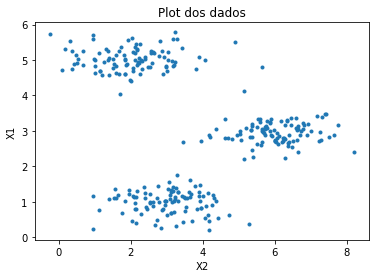

In [4]:
# Load an example dataset that we will be using
data = loadmat(os.path.join('Data', 'ex7data2.mat'))
X = data['X']
plt.plot(X[:,0], X[:,1], '.')
plt.xlabel('X2')
plt.ylabel('X1')
plt.title('Plot dos dados')

In [5]:
# encontrando as centroides iniciais
K = 3
initial_centroids = [np.array([3,3]), np.array([6,2]), np.array([8,5])]
idx = findClosestCentroids(X, initial_centroids)
print(idx[:3])

[0 2 1]


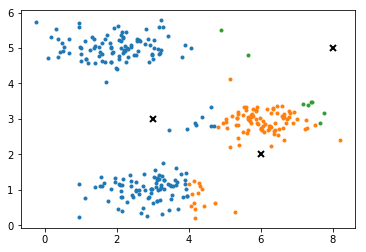

In [6]:
for i in range(K):
    ind = idx == i
    plt.plot(X[ind[:],0], X[ind[:],1], '.')
    plt.plot(initial_centroids[i][0], initial_centroids[i][1], 'xk', mew=2)

In [7]:
centroids = computeCentroids(X, idx, K)

print('Centroids computed after initial finding of closest centroids:')
print(centroids)
print('\nThe centroids should be')
print('   [ 2.428301 3.157924 ]')
print('   [ 5.813503 2.633656 ]')
print('   [ 7.119387 3.616684 ]')

Centroids computed after initial finding of closest centroids:
[[2.43843803 3.14015163]
 [5.81873176 2.63143356]
 [6.9074246  3.75972133]]

The centroids should be
   [ 2.428301 3.157924 ]
   [ 5.813503 2.633656 ]
   [ 7.119387 3.616684 ]


### 1.2 K-means on example dataset 

In [8]:
def runkMeans(X, initial_centroids, max_iters, plot_progress=True):
    
    # initial values
    m, n = X.shape
    K = len(initial_centroids)
    centroids = [ic for ic in initial_centroids]
    all_centroids = []
    idx = np.zeros(m)
    
    for ii in range(max_iters):
        
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
        all_centroids.append(centroids)
        
    if plot_progress:
        
        for j in range(K):
            x = [ac[j,0] for ac in all_centroids]
            y = [ac[j,1] for ac in all_centroids]
            plt.plot(x, y, 'x-', color='k', mew=2)
            
        for ii in range(K):
            ind = idx == ii
            plt.plot(X[ind[:],0], X[ind[:],1], '.')
        
    return centroids, idx

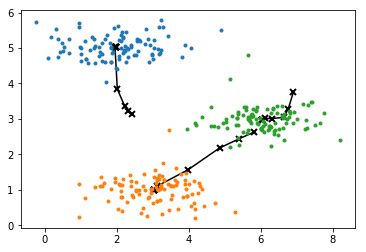

In [9]:
K = 3
max_iters = 10
initial_centroids = [np.array([3,3]), np.array([6,2]), 
                     np.array([8,5])]

centroids, idx = runkMeans(X, initial_centroids, max_iters)

### 1.3 Random initialization 

In [10]:
def kMeansInitCentroids(X, K):
    ind = np.random.permutation(X.shape[0])
    return X[ind[:K],:]

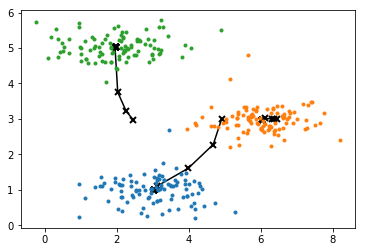

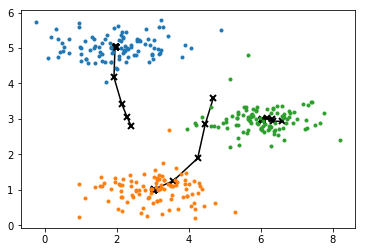

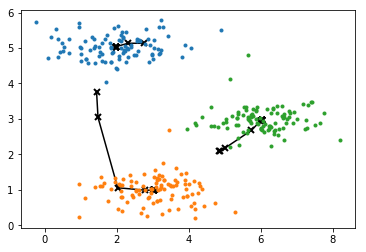

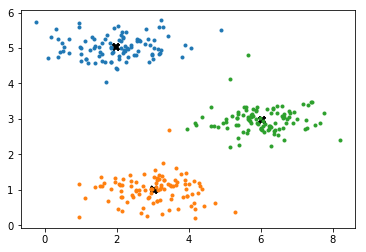

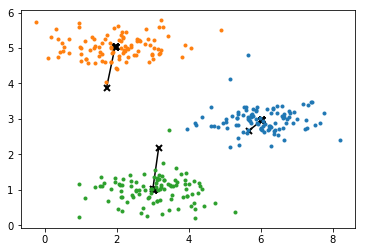

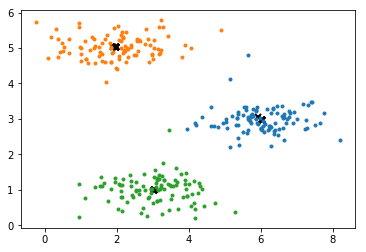

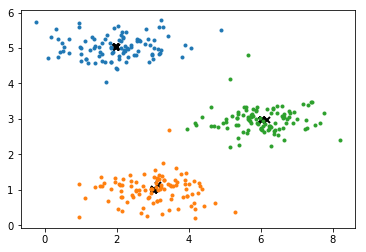

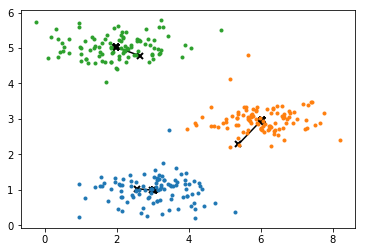

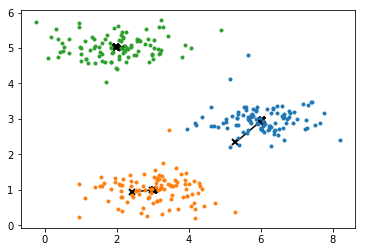

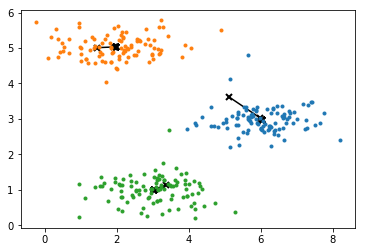

In [11]:
K = 3
max_iters = 20
loop_size = 10
for i in range(loop_size):
    plt.figure()
    initial_centroids = kMeansInitCentroids(X,K)
    centroids, idx = runkMeans(X, initial_centroids, max_iters)

### 1.4 Image compression with K-means

In [15]:
K = 16
max_iters = 10
A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
A /= 255
X = A.reshape(-1, 3)

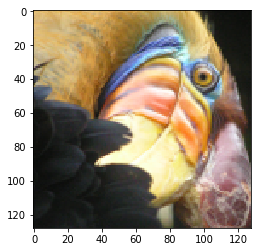

In [18]:
plt.imshow(A*255)

In [20]:
initial_centroids = kMeansInitCentroids(X, K)
centroids, idx = runkMeans(X, initial_centroids, max_iters, plot_progress=False)
# find closest members
idx = findClosestCentroids(X, centroids)

# map each pixex to its centroid value
X_recovered = centroids[idx,:]

# reshape
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], 3))

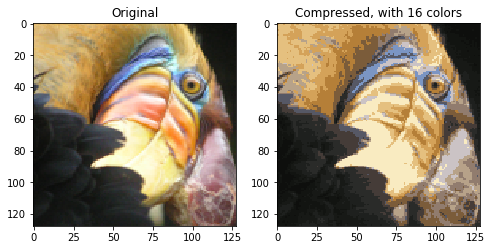

In [21]:
# Display the original image, rescale back by 255
fig, ax = pyplot.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(A*255)
ax[0].set_title('Original')
ax[0].grid(False)

# Display compressed image, rescale back by 255
ax[1].imshow(X_recovered*255)
ax[1].set_title('Compressed, with %d colors' % K)
ax[1].grid(False)

## 2 Principal Component Analysis


### 2.1 Example Dataset

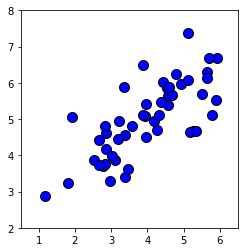

In [26]:
# Load the dataset into the variable X 
data = loadmat(os.path.join('Data', 'ex7data1.mat'))
X = data['X']

#  Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=1)
plt.axis([0.5, 6.5, 2, 8])
plt.gca().set_aspect('equal')
plt.grid(False)

## 2.2 Implementing PCA

In [27]:
def featureNormalize(X):
    # compute mean and standard deviation
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)  
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma  

def pca(X):
    m, n = X.shape
    # compute covariance matrix
    Sigma = np.dot(X.T, X) / m
    # SVD
    u, s, v = np.linalg.svd(Sigma)
    return u, s

def drawLine(p1, p2, *args, **kwargs):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], *args, **kwargs)

In [28]:
# feature normalize
X_norm, mu, sigma = featureNormalize(X)

# perform PCA
U, S = pca(X_norm)

Top eigenvector: U[:, 0] = [-0.707107 -0.707107]
 (you should expect to see [-0.707107 -0.707107])


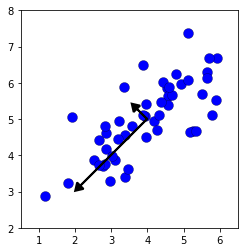

In [29]:
#  Draw the eigenvectors centered at mean of data. These lines show the
#  directions of maximum variations in the dataset.
fig, ax = pyplot.subplots()
ax.plot(X[:, 0], X[:, 1], 'bo', ms=10, mec='k', mew=0.25)

for i in range(2):
    ax.arrow(mu[0], mu[1], 1.5 * S[i]*U[0, i], 1.5 * S[i]*U[1, i],
             head_width=0.25, head_length=0.2, fc='k', ec='k', lw=2, zorder=1000)

ax.axis([0.5, 6.5, 2, 8])
ax.set_aspect('equal')
ax.grid(False)

print('Top eigenvector: U[:, 0] = [{:.6f} {:.6f}]'.format(U[0, 0], U[1, 0]))
print(' (you should expect to see [-0.707107 -0.707107])')

## 2.3 Dimensionality Reduction with PCA

In [30]:
def projectData(X, U, K):
    return np.dot(X, U[:,:K])

def recoverData(Z, U, K):
    return np.dot(Z, U[:,:K].T)

### 2.3.1 Projecting the data onto principal components

In [31]:
K = 1
Z = projectData(X_norm, U, 1)
print('Projection of the first example: {:.6f}'.format(Z[0, 0]))
print('(this value should be about    : 1.481274)')

Projection of the first example: 1.496313
(this value should be about    : 1.481274)


### 2.3.2 Reconstructing an approximation of the data

Approximation of the first example: [-1.058053 -1.058053]
       (this value should be about  [-1.047419 -1.047419])


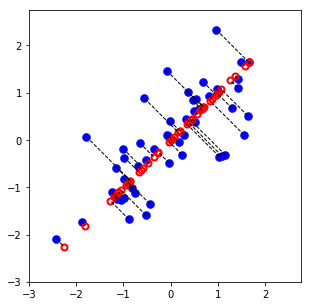

In [32]:
X_rec  = recoverData(Z, U, K)
print('Approximation of the first example: [{:.6f} {:.6f}]'.format(X_rec[0, 0], X_rec[0, 1]))
print('       (this value should be about  [-1.047419 -1.047419])')

#  Plot the normalized dataset (returned from featureNormalize)
fig, ax = pyplot.subplots(figsize=(5, 5))
ax.plot(X_norm[:, 0], X_norm[:, 1], 'bo', ms=8, mec='b', mew=0.5)
ax.set_aspect('equal')
ax.grid(False)
pyplot.axis([-3, 2.75, -3, 2.75])

# Draw lines connecting the projected points to the original points
ax.plot(X_rec[:, 0], X_rec[:, 1], 'ro', mec='r', mew=2, mfc='none')
for xnorm, xrec in zip(X_norm, X_rec):
    ax.plot([xnorm[0], xrec[0]], [xnorm[1], xrec[1]], '--k', lw=1)

### 2.4 Face Image Dataset

In [34]:
# função dentro do utils.py
def displayData(X, nrows=10, ncols=10):
    
    # set up array
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols,
                              figsize=(nrows,ncols))
    
    nblock = int(np.sqrt(X.shape[1]))
    
    # loop over randomly drawn numbers
    ct = 0
    for ii in range(nrows):
        for jj in range(ncols):
            #ind = np.random.randint(X.shape[0])
            tmp = X[ct,:].reshape(nblock, nblock, order='F')
            axarr[ii,jj].imshow(tmp, cmap='gray')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible=False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible=False)
            plt.minorticks_off()
            ct += 1
    
    fig.subplots_adjust(hspace=0, wspace=0)

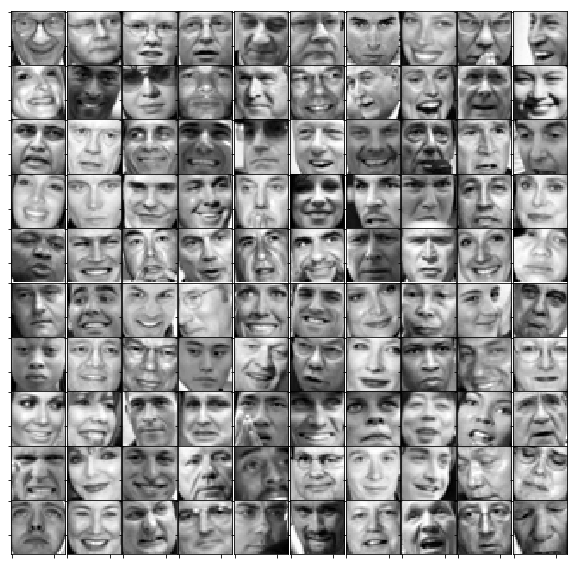

In [35]:
#  Load Face dataset
data = loadmat(os.path.join('Data', 'ex7faces.mat'))
X = data['X']
displayData(X)

#### 2.4.1 PCA on Faces

In [36]:
# feature normalization
X_norm, mu, sigma = featureNormalize(X)

# run PCA
U, S = pca(X_norm)

### 2.4.2 Dimensionality reduction

In [39]:
A = mpl.image.imread(os.path.join('Data', 'bird_small.png'))
A /= 255
X = A.reshape(-1, 3)

# perform the K-means clustering again here
K = 16
max_iters = 10
initial_centroids = kMeansInitCentroids(X, K)
centroids, idx = runkMeans(X, initial_centroids, max_iters, plot_progress=False)

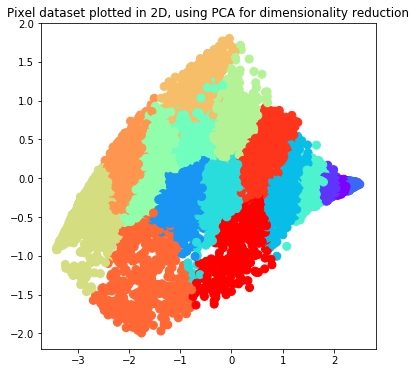

In [43]:
# Subtract the mean to use PCA
X_norm, mu, sigma = featureNormalize(X)

# PCA and project the data to 2D
U, S = pca(X_norm)
Z = projectData(X_norm, U, 2)


fig = pyplot.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.scatter(Z[:, 0], Z[:, 1], cmap='rainbow', c=idx[:], s=64)
ax.set_title('Pixel dataset plotted in 2D, using PCA for dimensionality reduction')
ax.grid(False)
pass

# 3. KMeans cluster com SkLearn

In [44]:
from sklearn.cluster import KMeans

data = loadmat(os.path.join('Data', 'ex7data2.mat'))
X = data['X']
k = 3
kmeans = KMeans(k, random_state=0).fit(X)

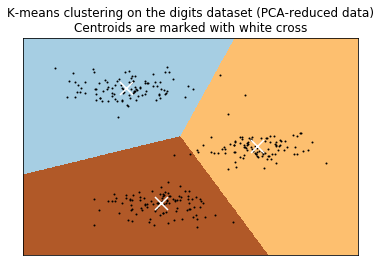

In [45]:
reduced_data = data['X']
k = 3
kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [46]:
print('Centroids obtidas no algorítimo próprio:\n',centroids)
print('\n\nCentroids obtidas no algorítimo sklearn:\n',kmeans.cluster_centers_)

Centroids obtidas no algorítimo próprio:
 [[1.95399466 5.02557006]
 [6.03366736 3.00052511]
 [3.04367119 1.01541041]]


Centroids obtidas no algorítimo sklearn:
 [[1.95399466 5.02557006]
 [6.03366736 3.00052511]
 [3.04367119 1.01541041]]


# 4. PCA com SkLearn

In [48]:
from sklearn.decomposition import PCA
data = loadmat(os.path.join('Data', 'ex7faces.mat'))
X = data['X']
X_norm, mu, sigma = featureNormalize(X)

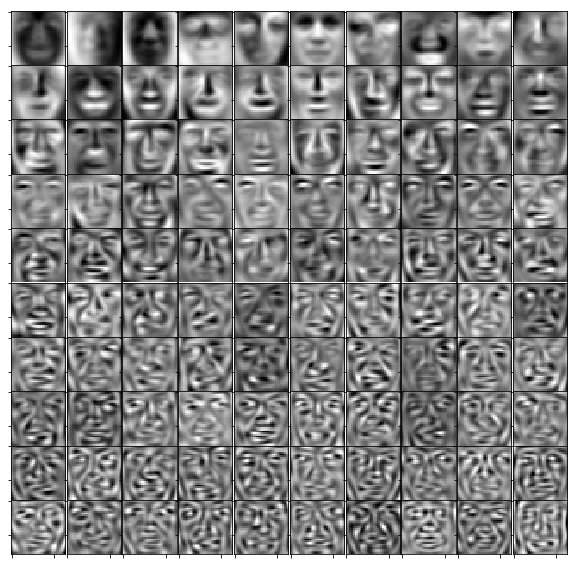

In [54]:
pca_sklearn = PCA()
pca_sklearn.fit(X_norm)
X2 = pca_sklearn.components_

displayData(X2)